In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
with open("ckpts/sft_bios_new_llama7B/checkpoint_20000/hf_model/factscores_test_medium.json", "r") as f:
    factscores = json.load(f)

decisions = factscores["decisions"]

lines_all = []
correct_all = []
bio_idxs = []
for i, decision in enumerate(decisions):
    if decision is not None: 
        for atomic_fact in decision:
            lines_all.append(atomic_fact["atom"])
            correct_all.append(atomic_fact["is_supported"])
            bio_idxs.append(i)
    else:
        print("here")
lines_all = np.array(lines_all)
correct_all = np.array(correct_all)
bio_idxs = np.array(bio_idxs)
true_samples = np.where(correct_all == True)[0]
false_samples = np.where(correct_all == False)[0]

In [4]:
rm_path = "ckpts/rm2_atmoic_facts_llama7B/checkpoint_10000/hf_model/"
rm_gpt3pt5_path = "ckpts/rm2_atmoic_facts_gpt3pt5_llama7B/checkpoint_10000/hf_model/" 


rm_samples_preds = np.load(rm_path + "test_medium_samples_preds.npy")
rm_samples_preds = (rm_samples_preds == " Yes.")
rm_gpt3pt5_samples_preds = np.load(rm_gpt3pt5_path + "test_medium_samples_preds.npy")
rm_gpt3pt5_samples_preds = (rm_gpt3pt5_samples_preds == " Yes.")

In [5]:
real_rewards = []
rm_rewards = []
rm_gpt3pt5_rewards = []

for i in range(len(decisions)):
    if decisions[i] is not None:
        fact_idxs = np.where(bio_idxs == i)[0]

        num_true = correct_all[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        real_rewards.append(2*num_true - 3*num_false)


        num_true = rm_samples_preds[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        rm_rewards.append(2*num_true - 3*num_false)

        num_true = rm_gpt3pt5_samples_preds[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        rm_gpt3pt5_rewards.append(2*num_true - 3*num_false)

In [6]:
real_rewards = np.array(real_rewards)
rm_rewards = np.array(rm_rewards)
rm_gpt3pt5_rewards = np.array(rm_gpt3pt5_rewards)

In [7]:
num_entities  = np.load("num_pretrain_entities/bios_test_points_medium.npy")
num_entities_bins = np.array([0, 200, 400, 600, 800, 1000, np.inf])

In [8]:
import scipy
def interquartile_mean(data):
    # Sort the data
    sorted_data = np.sort(data)

    # Calculate positions of Q1 and Q3
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)

    # Extract data between Q1 and Q3
    interquartile_data = sorted_data[(sorted_data >= q1) & (sorted_data <= q3)]

    # Calculate the mean of the interquartile data
    return np.mean(interquartile_data)


def get_bin_mean(x_axis, y_axis, bins):
    x_axis = np.array(x_axis)
    y_axis = np.array(y_axis)
    bin_avgs = []
    for i in range(len(bins)-1):
        idxs = np.where((x_axis >= bins[i]) & (x_axis < bins[i+1]))[0]
        # print(len(idxs))
        bin_avgs.append(np.mean(y_axis[idxs]))
    return np.array(bin_avgs)

def get_bin_iqm(x_axis, y_axis, bins):
    x_axis = np.array(x_axis)
    y_axis = np.array(y_axis)
    bin_avgs = []
    for i in range(len(bins)-1):
        idxs = np.where((x_axis >= bins[i]) & (x_axis < bins[i+1]))[0]
        # print(len(idxs))
        bin_avgs.append(interquartile_mean(y_axis[idxs]))
    return np.array(bin_avgs)

def get_bin_median(x_axis, y_axis, bins):
    x_axis = np.array(x_axis)
    y_axis = np.array(y_axis)
    bin_avgs = []
    for i in range(len(bins)-1):
        idxs = np.where((x_axis >= bins[i]) & (x_axis < bins[i+1]))[0]
        bin_avgs.append(np.median(y_axis[idxs]))
    return np.array(bin_avgs)

/tmp/ipykernel_15381/2602533163.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x,  np.array(binned_real_rewards), "o-", label="Ground Truth", markersize=15, linewidth=5, linestyle="--", color="black", alpha=0.8)


Text(0.5, 1.0, 'Biography Generation')

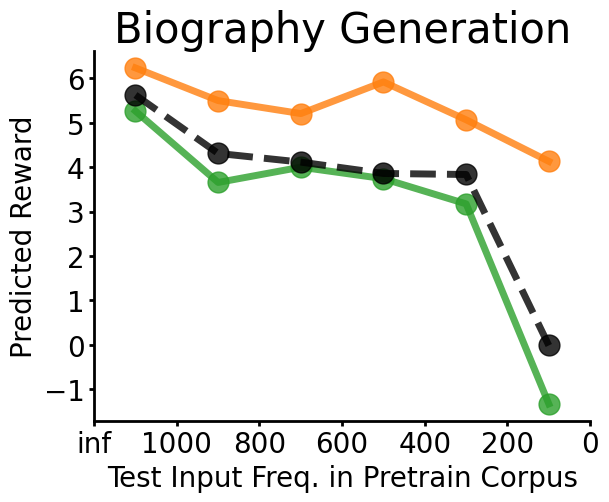

In [10]:
x = np.arange(len(num_entities_bins)-1)


binned_rm_rewards = np.flip(get_bin_iqm(num_entities, rm_rewards, num_entities_bins))
plt.plot(x,  np.array(binned_rm_rewards), "o-", label="llama2 7B RM", markersize=15, linewidth=5, alpha=0.8, color="C2")

binned_rm_gpt3pt5_rewards = np.flip(get_bin_iqm(num_entities, rm_gpt3pt5_rewards, num_entities_bins))
plt.plot(x,  np.array(binned_rm_gpt3pt5_rewards), "o-", label="GPT3.5 RM", markersize=15, linewidth=5, alpha=0.8,  color="C1")

binned_real_rewards = np.flip(get_bin_iqm(num_entities, real_rewards, num_entities_bins))
plt.plot(x,  np.array(binned_real_rewards), "o-", label="Ground Truth", markersize=15, linewidth=5, linestyle="--", color="black", alpha=0.8)

# plt.legend()

plt.xticks(np.append(x, len(num_entities_bins)-1)-0.5, ["inf", "1000", "800", "600", "400", "200", "0"], fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("Test Input Freq. in Pretrain Corpus", fontsize=20)
plt.ylabel("Predicted Reward", fontsize=20)

#make spines thicker
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', width=2)

#remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.legend(fontsize=20)
# plt.ylim(-7, 10)

plt.title("Biography Generation", fontsize=30)